In [1]:
!pip install "gluonts[mxnet, torch]"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mxnet as mx


from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.model.n_beats import NBEATSEstimator
from gluonts.mx import Trainer
from gluonts.dataset.split import split

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
seed = 42
np.random.seed(seed)
mx.random.seed(seed)

In [4]:
AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
TS_COLUMN = "Passengers"

ts_data = pd.read_csv(AIRLINES_CSV_URL, index_col=0, parse_dates=True)
ts_data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
train_size = int(len(ts_data) * 0.8)
test_size = len(ts_data) - train_size

dataset = PandasDataset(ts_data, target=TS_COLUMN)

forecast = 1
windows = int(test_size/forecast)

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(prediction_length=forecast, windows=windows)

In [6]:
model = NBEATSEstimator(
    prediction_length=forecast, freq="M",
    context_length=36,
    trainer=Trainer(epochs=25, learning_rate=0.001)
).train(training_data)


100%|██████████| 50/50 [00:17<00:00,  2.80it/s, epoch=25/25, avg_epoch_loss=1.47]


In [7]:
fcast = list(model.predict(test_data.input))
test_outputs =  np.array([x.samples for x in fcast]).reshape(-1)
test_rmse = np.sqrt(mean_squared_error(test_outputs, ts_data.iloc[train_size:].values))

print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 19.6667


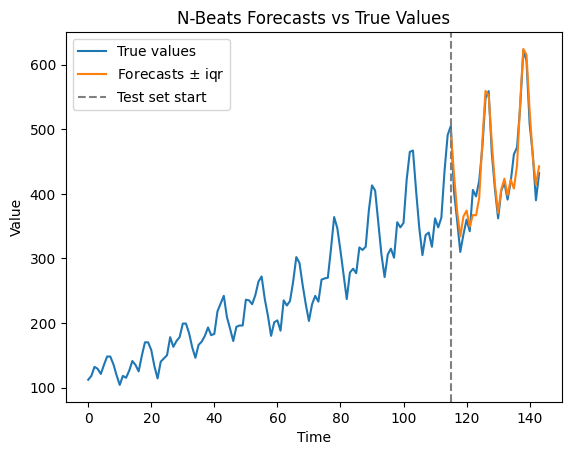

In [8]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))

test_start_index = len(ts_data) - test_size

plt.plot(ts_data[TS_COLUMN].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label="Forecasts $\pm$ iqr",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("N-Beats Forecasts vs True Values")
plt.show()

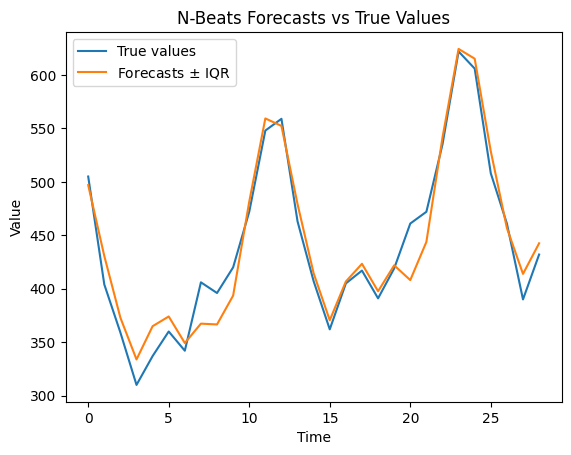

In [9]:
plt.plot(ts_data[TS_COLUMN].values[train_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label="Forecasts $\pm$ IQR",
)

# plt.fill_between(range(0, test_size), test_outputs-test_iqr, test_outputs+test_iqr, alpha=0.3, facecolor='#FF9848')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("N-Beats Forecasts vs True Values")
plt.show()